# Introduction

時系列データの不確実性を考慮した時系列予測を行います。


# 各種ライブラリの取得



In [1]:
%matplotlib inline 
import numpy as np
import pylab
from pandas import read_csv
from random import gauss
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st
import sys
from matplotlib import animation as ani
import sklearn.metrics as mt
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, LSTM, GRU, RepeatVector
from keras.layers.core import Dense, Lambda
from keras import objectives
from sklearn.preprocessing import MinMaxScaler
from copy import copy 
plt.style.use('ggplot')

/Users/masayaohgushi/.virtualenvs/time_series_anomaly_detect/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
Using TensorFlow backend.


# 気温データの取得

直接HTMLから読み込んでpandas形式にしてくれる関数です。

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

In [2]:
wave_data = read_csv('https://raw.githubusercontent.com/jamesrobertlloyd/gpss-research/master/data/tsdlr_5050/daily-minimum-temperatures-in-me-train.csv', header=None, names=["Date", "Temp"])
wave_data = wave_data.sort_values(by=['Date'])

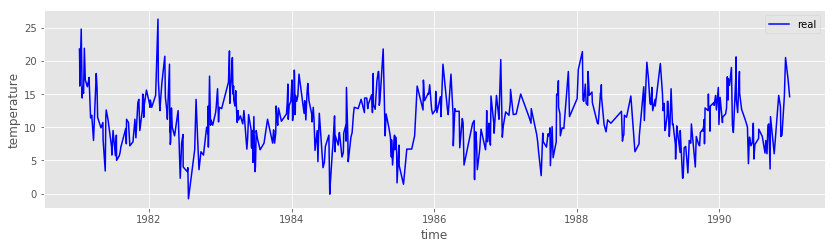

In [3]:
X_orig = wave_data["Temp"].values
X_day = wave_data["Date"].values

def show_graph(day, data, label, color="b"):
    pylab.figure(figsize=(14, 8))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color=color, label=label)
    pylab.legend(loc='upper right')
    pylab.show()
    
show_graph(X_day, X_orig, 'real')

# データの分割

- 学習データ
- テストデータ

In [4]:
print(X_orig.shape)

X_train = X_orig[:400]
X_test = X_orig[400:]
X_train_day = X_day[:400]
X_test_day = X_day[400:]

(500,)


# 学習データ

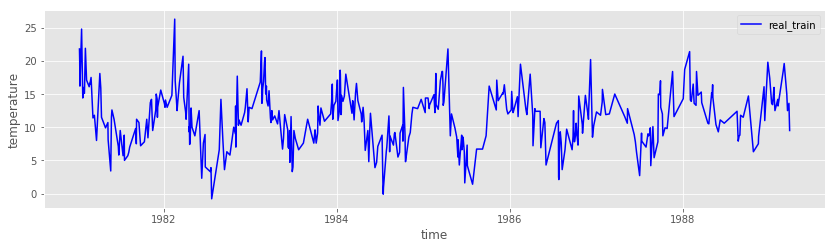

In [5]:
show_graph(X_train_day, X_train, 'real_train')

# テストデータ

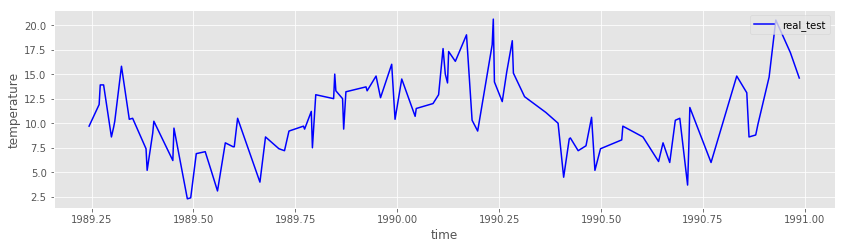

In [6]:
show_graph(X_test_day, X_test, 'real_test')

# 学習データのスムージング

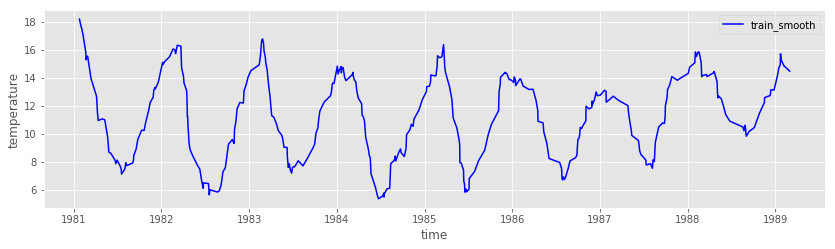

In [33]:
def smooth(x, window_len=11):

    w = np.ones(window_len, 'd')
    
    y = np.convolve( w / w.sum(), x, mode='valid')
    return y

half_window = 5
X_smooth_train = smooth(X_train)
X_train_day_smooth = X_train_day[half_window:-half_window]

show_graph(X_train_day_smooth, X_smooth_train, 'train_smooth')

# テストデータのスムージング

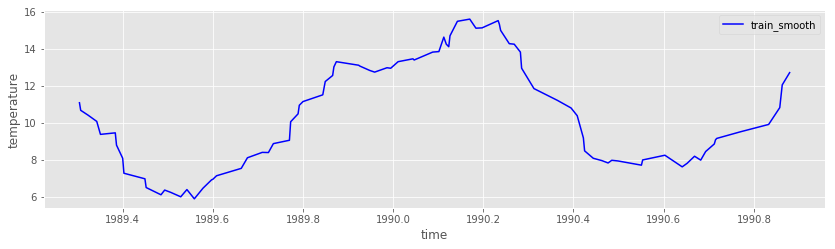

In [34]:
X_smooth_test = smooth(X_test)
X_test_day_smooth = X_test_day[half_window:-half_window]

show_graph(X_test_day_smooth, X_smooth_test, 'train_smooth')

# 前処理

- `get_data`: データを前処理して深層学習で扱える形に変換する
- `transform_data`: データを正規化して学習が容易な形に変更する。データを正規化後の値に戻して予測結果が適切か確認する

In [35]:
def get_data(data, time_steps: int=3):
    dataX = []
    print(data.shape)
    for i in range(len(data) - time_steps - 1):
        x = data[i:(i + time_steps), :]
        dataX.append(x)
    return np.array(dataX)

def transform_data(original_data: np.array, inverse_option: bool, scaler: object):
    data_shape = original_data.shape
    data = original_data.reshape(-1, 1)
    if inverse_option is True:
        print('before max {}'.format(max(data)))
        print('Inverse')
        data = scaler.inverse_transform(data)
        print('after max {}'.format(max(data)))
    else:
        print('before max {}'.format(max(data)))
        print('Normalize')
        data = scaler.fit_transform(data)
        print(max(data))
        print('after max {}'.format(max(data)))
    data = data.reshape(data_shape)
    return data, scaler

def prepare_data(original_data, time_steps):
    copy_data = original_data.copy()
    scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
    data, scaler = transform_data(original_data=copy_data, 
                              inverse_option=False, scaler=scaler)
    data = np.asarray(data)
    data = data.reshape(-1, 1)
    x = get_data(data, time_steps=time_steps)
    return x, scaler

time_steps = 3

x, scaler = prepare_data(X_smooth_train, time_steps)

input_dim = x.shape[-1]
timesteps = x.shape[1]
print(x.shape)

before max [18.18181818]
Normalize
[1.]
after max [1.]
(390, 1)
(386, 3, 1)


# モデルの作成

- `create_model`でモデルを作成しています。指定できるのは
   - timestepsの幅
   - ノードの数
   - 自身の状態をリセットするかしないかを指定する`stateful`(周期的な波形は`True`の方が若干良くなります。)
   - `model_option`でGRUもしくはLSTMを選択できます。
   - `optimizer`で設定したい`optimizer`を指定できます。デファオルトでは`adam`が入っています。

In [36]:
def create_model(input_dim,
                 time_steps,
                 latent_dim,
                 # データが一つしかないので1しか選べない
                 batch_size=1,
                 model_option='lstm',
                 optimizer='adam',
                 drop_out=0.5,
                ):
    x = Input(shape=(time_steps, input_dim,))

    if model_option == 'lstm':
        h = LSTM(latent_dim, stateful=False, return_sequences=True, dropout=drop_out)(x)
    elif model_option == 'gru':
        h = GRU(latent_dim, stateful=False, return_sequences=True, dropout=drop_out)(x)

    out = Dense(input_dim)(h)

    model = Model(x, out)
    model.summary()

    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# 予測関数

In [11]:
def predict_model_show_graph(day, x, scaler, model):
    prepare_value = x.copy()
    preds = model.predict(prepare_value)

    x_scale, scaler = transform_data(original_data=prepare_value, inverse_option=True, scaler=scaler)
    predict_scale, scaler = transform_data(original_data=preds, inverse_option=True, scaler=scaler)
    
    plt.figure(figsize=(14, 8))
    plt.plot(day, x_scale[:, 0, 0], color='r', label='data')
    plt.plot(day, predict_scale[:, 0, 0], color='b', label='predict')
    plt.legend()
    plt.show()
    return predict_scale, x_scale

# Dropoutにより不確実性を導出

ノイズが少ない分布を仮定

1,2,3,4%のノイズを付与

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_66 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_66 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 14ms/step - loss: 0.2036 - mean_squared_error: 0.2036
Epoch 2/200
386/386 [==============================] - 0s 189us/step - loss: 0.0929 - mean_squared_error: 0.0929
Epoch 3/200
386/386 [==============================] - 0s 197us/step - loss: 0.0632 - mean_squared_error: 0.0632
Epoch 4/200
386/386 [==============================] - 0s 203us/

386/386 [==============================] - 0s 205us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 67/200
386/386 [==============================] - 0s 217us/step - loss: 0.0029 - mean_squared_error: 0.0029
Epoch 68/200
386/386 [==============================] - 0s 216us/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 69/200
386/386 [==============================] - 0s 221us/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 70/200
386/386 [==============================] - 0s 210us/step - loss: 1.9210e-04 - mean_squared_error: 1.9210e-04
Epoch 71/200
386/386 [==============================] - 0s 201us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 72/200
386/386 [==============================] - 0s 203us/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 73/200
386/386 [==============================] - 0s 224us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 74/200
386/386 [==============================] - 0s 218us/step - loss: 2.4669e-04 - me

386/386 [==============================] - 0s 187us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 137/200
386/386 [==============================] - 0s 202us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 138/200
386/386 [==============================] - 0s 206us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 139/200
386/386 [==============================] - 0s 195us/step - loss: 5.4608e-04 - mean_squared_error: 5.4608e-04
Epoch 140/200
386/386 [==============================] - 0s 201us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 141/200
386/386 [==============================] - 0s 189us/step - loss: 0.0018 - mean_squared_error: 0.0018
Epoch 142/200
386/386 [==============================] - 0s 189us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 143/200
386/386 [==============================] - 0s 188us/step - loss: 6.7999e-04 - mean_squared_error: 6.7999e-04
Epoch 144/200
386/386 [==============================] - 0s 189us/step - loss:

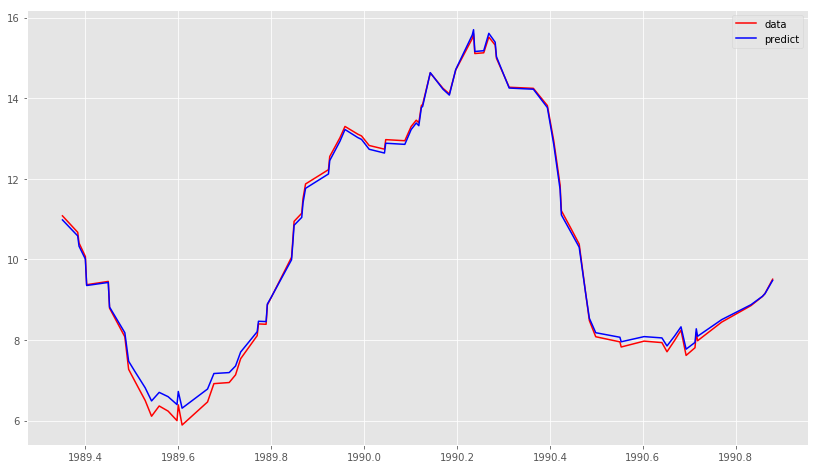

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_67 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_67 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_67 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 14ms/step - loss: 0.1616 - mean_squared_error: 0.1616
Epoch 2/200
386/386 [==============================] - 0s 195us/step - loss: 0.0670 - mean_squared_error: 0.0670
Epoch 3/200
386/386 [==============================] - 0s 195us/step - loss: 0.0547 - mean_squared_error: 0.0547
Epoch 4/200
386/386 [==============================] - 0s 203us/

386/386 [==============================] - 0s 189us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 67/200
386/386 [==============================] - 0s 194us/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 68/200
386/386 [==============================] - 0s 192us/step - loss: 0.0059 - mean_squared_error: 0.0059
Epoch 69/200
386/386 [==============================] - 0s 192us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 70/200
386/386 [==============================] - 0s 194us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 71/200
386/386 [==============================] - 0s 196us/step - loss: 0.0046 - mean_squared_error: 0.0046
Epoch 72/200
386/386 [==============================] - 0s 191us/step - loss: 0.0041 - mean_squared_error: 0.0041
Epoch 73/200
386/386 [==============================] - 0s 197us/step - loss: 0.0024 - mean_squared_error: 0.0024
Epoch 74/200
386/386 [==============================] - 0s 202us/step - loss: 0.0041 - mean_squared_e

386/386 [==============================] - 0s 197us/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 138/200
386/386 [==============================] - 0s 198us/step - loss: 0.0012 - mean_squared_error: 0.0012
Epoch 139/200
386/386 [==============================] - 0s 198us/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 140/200
386/386 [==============================] - 0s 190us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 141/200
386/386 [==============================] - 0s 194us/step - loss: 0.0040 - mean_squared_error: 0.0040
Epoch 142/200
386/386 [==============================] - 0s 187us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 143/200
386/386 [==============================] - 0s 192us/step - loss: 0.0011 - mean_squared_error: 0.0011  
Epoch 144/200
386/386 [==============================] - 0s 187us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 145/200
386/386 [==============================] - 0s 195us/step - loss: 0.0029 - mean

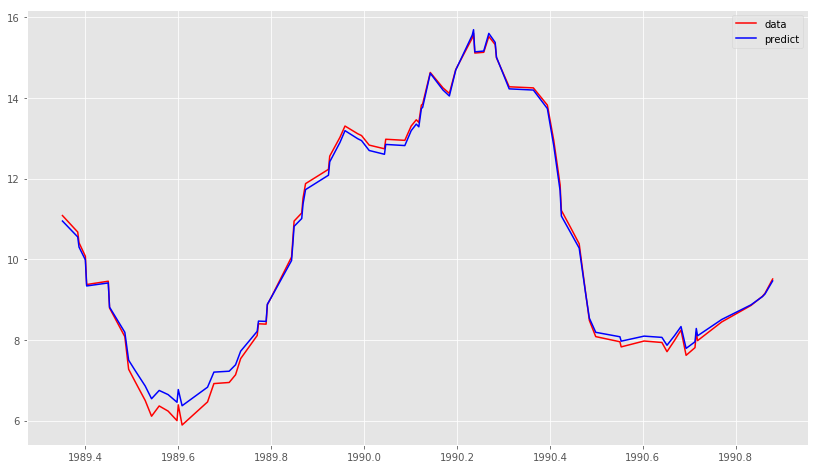

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_68 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_68 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 5s 14ms/step - loss: 0.1676 - mean_squared_error: 0.1676
Epoch 2/200
386/386 [==============================] - 0s 191us/step - loss: 0.0731 - mean_squared_error: 0.0731
Epoch 3/200
386/386 [==============================] - 0s 192us/step - loss: 0.0570 - mean_squared_error: 0.0570
Epoch 4/200
386/386 [==============================] - 0s 192us/

386/386 [==============================] - 0s 190us/step - loss: 0.0069 - mean_squared_error: 0.0069
Epoch 67/200
386/386 [==============================] - 0s 192us/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 68/200
386/386 [==============================] - 0s 193us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 69/200
386/386 [==============================] - 0s 193us/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 70/200
386/386 [==============================] - 0s 196us/step - loss: 0.0067 - mean_squared_error: 0.0067
Epoch 71/200
386/386 [==============================] - 0s 208us/step - loss: 0.0063 - mean_squared_error: 0.0063
Epoch 72/200
386/386 [==============================] - 0s 202us/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 73/200
386/386 [==============================] - 0s 211us/step - loss: 0.0077 - mean_squared_error: 0.0077
Epoch 74/200
386/386 [==============================] - 0s 203us/step - loss: 0.0072 - mean_squared_e

386/386 [==============================] - 0s 203us/step - loss: 0.0028 - mean_squared_error: 0.0028
Epoch 138/200
386/386 [==============================] - 0s 194us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 139/200
386/386 [==============================] - 0s 195us/step - loss: 0.0030 - mean_squared_error: 0.0030
Epoch 140/200
386/386 [==============================] - 0s 190us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 141/200
386/386 [==============================] - 0s 191us/step - loss: 0.0047 - mean_squared_error: 0.0047
Epoch 142/200
386/386 [==============================] - 0s 191us/step - loss: 0.0031 - mean_squared_error: 0.0031
Epoch 143/200
386/386 [==============================] - 0s 192us/step - loss: 0.0038 - mean_squared_error: 0.0038
Epoch 144/200
386/386 [==============================] - 0s 193us/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 145/200
386/386 [==============================] - 0s 202us/step - loss: 0.0034 - mean_s

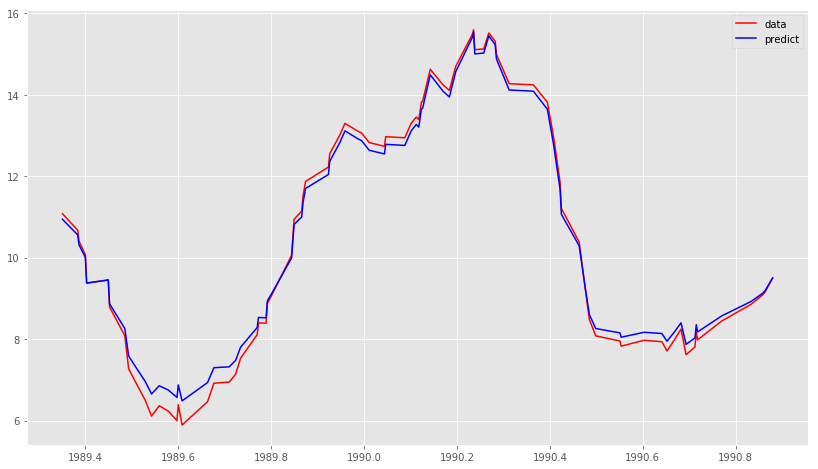

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_69 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_69 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 15ms/step - loss: 0.2130 - mean_squared_error: 0.2130
Epoch 2/200
386/386 [==============================] - 0s 192us/step - loss: 0.0945 - mean_squared_error: 0.0945
Epoch 3/200
386/386 [==============================] - 0s 198us/step - loss: 0.0630 - mean_squared_error: 0.0630
Epoch 4/200
386/386 [==============================] - 0s 194us/

386/386 [==============================] - 0s 199us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 67/200
386/386 [==============================] - 0s 190us/step - loss: 0.0095 - mean_squared_error: 0.0095
Epoch 68/200
386/386 [==============================] - 0s 190us/step - loss: 0.0072 - mean_squared_error: 0.0072
Epoch 69/200
386/386 [==============================] - 0s 192us/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 70/200
386/386 [==============================] - 0s 196us/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 71/200
386/386 [==============================] - 0s 192us/step - loss: 0.0071 - mean_squared_error: 0.0071
Epoch 72/200
386/386 [==============================] - 0s 190us/step - loss: 0.0056 - mean_squared_error: 0.0056
Epoch 73/200
386/386 [==============================] - 0s 191us/step - loss: 0.0065 - mean_squared_error: 0.0065
Epoch 74/200
386/386 [==============================] - 0s 217us/step - loss: 0.0079 - mean_squared_e

386/386 [==============================] - 0s 197us/step - loss: 0.0021 - mean_squared_error: 0.0021
Epoch 138/200
386/386 [==============================] - 0s 202us/step - loss: 0.0048 - mean_squared_error: 0.0048
Epoch 139/200
386/386 [==============================] - 0s 196us/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 140/200
386/386 [==============================] - 0s 197us/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 141/200
386/386 [==============================] - 0s 206us/step - loss: 0.0043 - mean_squared_error: 0.0043
Epoch 142/200
386/386 [==============================] - 0s 202us/step - loss: 0.0052 - mean_squared_error: 0.0052
Epoch 143/200
386/386 [==============================] - 0s 196us/step - loss: 0.0049 - mean_squared_error: 0.0049
Epoch 144/200
386/386 [==============================] - 0s 234us/step - loss: 0.0055 - mean_squared_error: 0.0055
Epoch 145/200
386/386 [==============================] - 0s 201us/step - loss: 0.0048 - mean_s

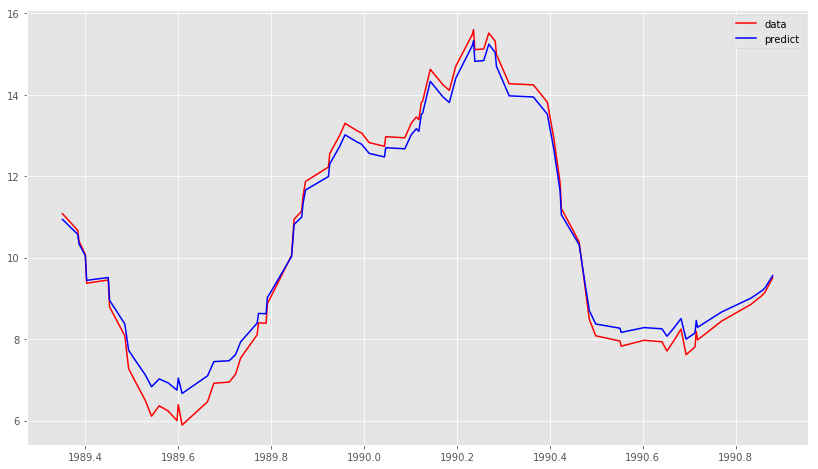

In [118]:
drop_out_list = [0.01, 0.02, 0.03, 0.04]
predict_list = []
var_list = []

for drop_out in drop_out_list:
    model = create_model(input_dim, 
                         time_steps=time_steps,
                         latent_dim=120,
                         model_option='lstm',
                         drop_out=drop_out,
                        )
    model.fit(x, x, epochs=200)
    window = time_steps
    x_test, scaler = prepare_data(X_smooth_test, time_steps)
    predict_test, x_scale_train = predict_model_show_graph(X_test_day_smooth[window + 1:], x_test, scaler, model)
    predict_list.append(predict_test)
    var_list.append(np.average(np.subtract(x_test, predict_test) ** 2))

# RMSEと分散を計算

In [119]:
average_predict = np.average(predict_list, axis=0)
average_predict = np.swapaxes(average_predict, 0, 1)[0]
average_predict = np.swapaxes(average_predict, 0, 1)[0]
rmse = np.sqrt(np.average(np.subtract(X_smooth_test[window + 1:], average_predict) ** 2))
variance = np.sqrt(np.average(var_list))
print('rmse:', rmse)
print('variance: ', variance)

rmse: 1.4169138976245477
variance:  10.218128770063755


In [120]:
noise_low_drop_out = [np.random.normal(y_p, variance) for y_p in average_predict]

# 予測の上限と下限のグラフを表示

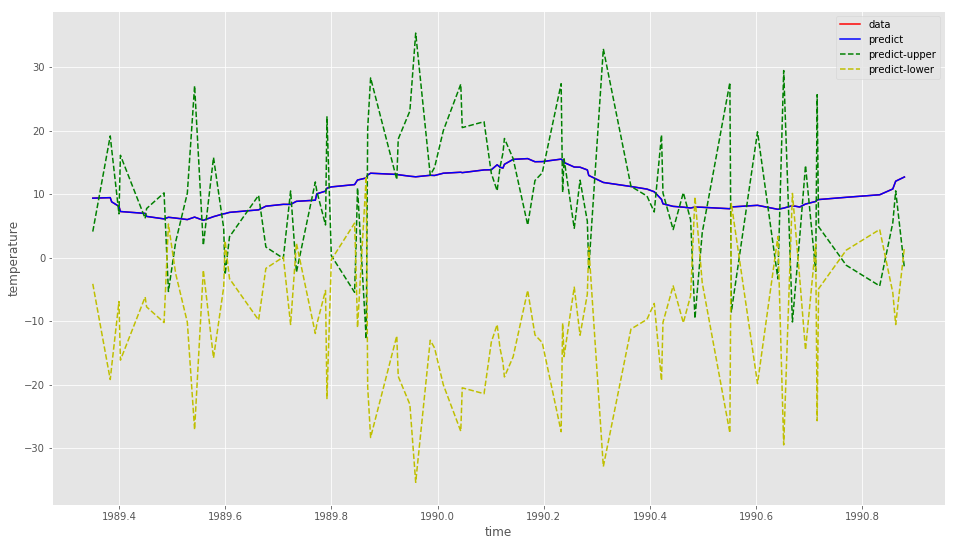

In [121]:
def show_three_graph(day, data, predict, predict_upper, predict_lower):
    pylab.figure(figsize=(16, 20))
    pylab.subplot(211)
    pylab.xlabel('time')
    pylab.ylabel('temperature')
    pylab.plot(day, data, color='r', label='data')
    pylab.plot(day, data, color='b', label='predict')
    pylab.plot(day, predict_upper, color='g', linestyle='dashed', label='predict-upper')
    pylab.plot(day, predict_lower, color='y', linestyle='dashed', label='predict-lower')
    pylab.legend(loc='upper right')
    pylab.show()

show_three_graph(X_test_day_smooth[window + 1:], 
                 X_smooth_test[window + 1:], 
                 average_predict, 
                 noise_low_drop_out, 
                 -1 * np.array(noise_low_drop_out))

# Coverageを計算

In [123]:
X_test = X_smooth_test[window + 1:]
noise = np.array(noise_low_drop_out)
coverage_test = []

for i in range(X_test.shape[0]):
    if noise[i] > X_test[i]:  # noqa
        coverage_test.append(True)
    elif -1.0 * noise[i] < X_test[i]:  # noqa
        coverage_test.append(True)
    else:
        coverage_test.append(False)
        
print('Coverage:', sum(coverage_test) / len(coverage_test))

Coverage: 0.9534883720930233


# Dropoutにより不確実性を導出

ノイズが中程度の分布を仮定

10,20,30,40%のノイズを付与

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_70 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_70 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_70 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 15ms/step - loss: 0.1988 - mean_squared_error: 0.1988
Epoch 2/200
386/386 [==============================] - 0s 200us/step - loss: 0.0873 - mean_squared_error: 0.0873
Epoch 3/200
386/386 [==============================] - 0s 199us/step - loss: 0.0690 - mean_squared_error: 0.0690
Epoch 4/200
386/386 [==============================] - 0s 202us/

386/386 [==============================] - 0s 200us/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 67/200
386/386 [==============================] - 0s 211us/step - loss: 0.0130 - mean_squared_error: 0.0130
Epoch 68/200
386/386 [==============================] - 0s 204us/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 69/200
386/386 [==============================] - 0s 197us/step - loss: 0.0101 - mean_squared_error: 0.0101
Epoch 70/200
386/386 [==============================] - 0s 219us/step - loss: 0.0109 - mean_squared_error: 0.0109
Epoch 71/200
386/386 [==============================] - 0s 199us/step - loss: 0.0094 - mean_squared_error: 0.0094
Epoch 72/200
386/386 [==============================] - 0s 200us/step - loss: 0.0110 - mean_squared_error: 0.0110
Epoch 73/200
386/386 [==============================] - 0s 195us/step - loss: 0.0097 - mean_squared_error: 0.0097
Epoch 74/200
386/386 [==============================] - 0s 196us/step - loss: 0.0097 - mean_squared_e

386/386 [==============================] - 0s 199us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 138/200
386/386 [==============================] - 0s 213us/step - loss: 0.0066 - mean_squared_error: 0.0066
Epoch 139/200
386/386 [==============================] - 0s 202us/step - loss: 0.0062 - mean_squared_error: 0.0062
Epoch 140/200
386/386 [==============================] - 0s 203us/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 141/200
386/386 [==============================] - 0s 195us/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 142/200
386/386 [==============================] - 0s 200us/step - loss: 0.0058 - mean_squared_error: 0.0058
Epoch 143/200
386/386 [==============================] - 0s 199us/step - loss: 0.0064 - mean_squared_error: 0.0064
Epoch 144/200
386/386 [==============================] - 0s 206us/step - loss: 0.0061 - mean_squared_error: 0.0061
Epoch 145/200
386/386 [==============================] - 0s 197us/step - loss: 0.0063 - mean_s

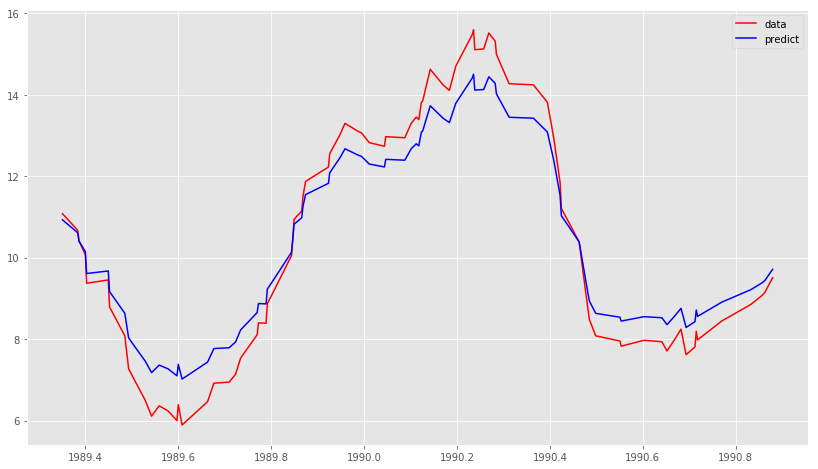

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_71 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_71 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_71 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 15ms/step - loss: 0.2215 - mean_squared_error: 0.2215
Epoch 2/200
386/386 [==============================] - 0s 200us/step - loss: 0.1090 - mean_squared_error: 0.1090
Epoch 3/200
386/386 [==============================] - 0s 200us/step - loss: 0.0787 - mean_squared_error: 0.0787
Epoch 4/200
386/386 [==============================] - 0s 204us/

386/386 [==============================] - 0s 195us/step - loss: 0.0164 - mean_squared_error: 0.0164
Epoch 67/200
386/386 [==============================] - 0s 191us/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 68/200
386/386 [==============================] - 0s 192us/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 69/200
386/386 [==============================] - 0s 192us/step - loss: 0.0174 - mean_squared_error: 0.0174
Epoch 70/200
386/386 [==============================] - 0s 198us/step - loss: 0.0168 - mean_squared_error: 0.0168
Epoch 71/200
386/386 [==============================] - 0s 202us/step - loss: 0.0161 - mean_squared_error: 0.0161
Epoch 72/200
386/386 [==============================] - 0s 198us/step - loss: 0.0151 - mean_squared_error: 0.0151
Epoch 73/200
386/386 [==============================] - 0s 192us/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 74/200
386/386 [==============================] - 0s 197us/step - loss: 0.0130 - mean_squared_e

386/386 [==============================] - 0s 200us/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 138/200
386/386 [==============================] - 0s 200us/step - loss: 0.0081 - mean_squared_error: 0.0081
Epoch 139/200
386/386 [==============================] - 0s 202us/step - loss: 0.0080 - mean_squared_error: 0.0080
Epoch 140/200
386/386 [==============================] - 0s 201us/step - loss: 0.0091 - mean_squared_error: 0.0091
Epoch 141/200
386/386 [==============================] - 0s 201us/step - loss: 0.0099 - mean_squared_error: 0.0099
Epoch 142/200
386/386 [==============================] - 0s 202us/step - loss: 0.0079 - mean_squared_error: 0.0079
Epoch 143/200
386/386 [==============================] - 0s 206us/step - loss: 0.0092 - mean_squared_error: 0.0092
Epoch 144/200
386/386 [==============================] - 0s 214us/step - loss: 0.0128 - mean_squared_error: 0.0128
Epoch 145/200
386/386 [==============================] - 0s 205us/step - loss: 0.0086 - mean_s

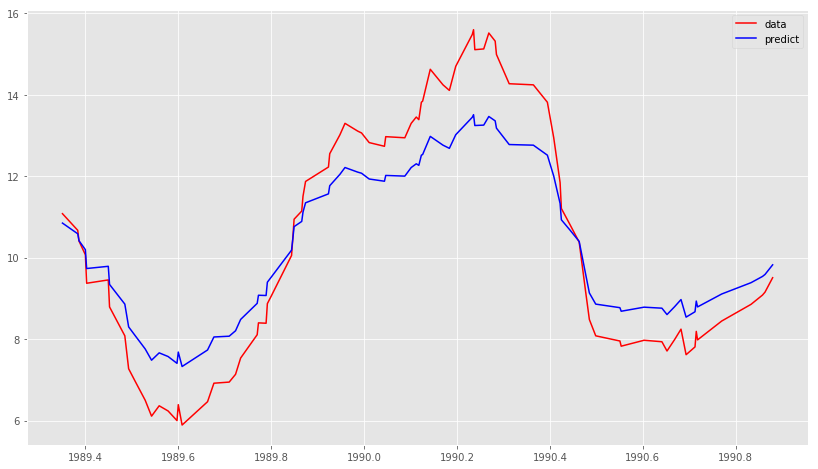

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_72 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_72 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_72 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 15ms/step - loss: 0.1822 - mean_squared_error: 0.1822
Epoch 2/200
386/386 [==============================] - 0s 201us/step - loss: 0.0972 - mean_squared_error: 0.0972
Epoch 3/200
386/386 [==============================] - 0s 206us/step - loss: 0.0735 - mean_squared_error: 0.0735
Epoch 4/200
386/386 [==============================] - 0s 206us/

386/386 [==============================] - 0s 199us/step - loss: 0.0192 - mean_squared_error: 0.0192
Epoch 67/200
386/386 [==============================] - 0s 203us/step - loss: 0.0182 - mean_squared_error: 0.0182
Epoch 68/200
386/386 [==============================] - 0s 201us/step - loss: 0.0204 - mean_squared_error: 0.0204
Epoch 69/200
386/386 [==============================] - 0s 203us/step - loss: 0.0170 - mean_squared_error: 0.0170
Epoch 70/200
386/386 [==============================] - 0s 206us/step - loss: 0.0194 - mean_squared_error: 0.0194
Epoch 71/200
386/386 [==============================] - 0s 201us/step - loss: 0.0183 - mean_squared_error: 0.0183
Epoch 72/200
386/386 [==============================] - 0s 198us/step - loss: 0.0203 - mean_squared_error: 0.0203
Epoch 73/200
386/386 [==============================] - 0s 201us/step - loss: 0.0193 - mean_squared_error: 0.0193
Epoch 74/200
386/386 [==============================] - 0s 200us/step - loss: 0.0173 - mean_squared_e

386/386 [==============================] - 0s 193us/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 138/200
386/386 [==============================] - 0s 199us/step - loss: 0.0140 - mean_squared_error: 0.0140
Epoch 139/200
386/386 [==============================] - 0s 202us/step - loss: 0.0138 - mean_squared_error: 0.0138
Epoch 140/200
386/386 [==============================] - 0s 203us/step - loss: 0.0119 - mean_squared_error: 0.0119
Epoch 141/200
386/386 [==============================] - 0s 202us/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 142/200
386/386 [==============================] - 0s 202us/step - loss: 0.0117 - mean_squared_error: 0.0117
Epoch 143/200
386/386 [==============================] - 0s 220us/step - loss: 0.0123 - mean_squared_error: 0.0123
Epoch 144/200
386/386 [==============================] - 0s 203us/step - loss: 0.0126 - mean_squared_error: 0.0126
Epoch 145/200
386/386 [==============================] - 0s 193us/step - loss: 0.0136 - mean_s

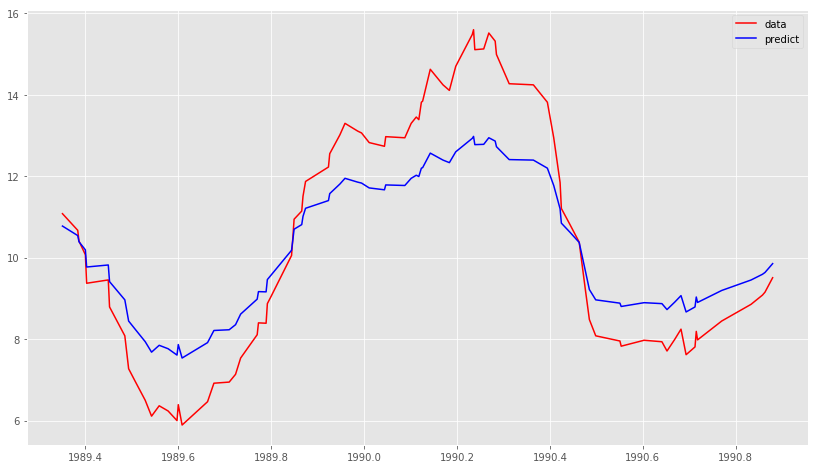

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_73 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_73 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 15ms/step - loss: 0.1919 - mean_squared_error: 0.1919
Epoch 2/200
386/386 [==============================] - 0s 193us/step - loss: 0.1003 - mean_squared_error: 0.1003
Epoch 3/200
386/386 [==============================] - 0s 193us/step - loss: 0.0832 - mean_squared_error: 0.0832
Epoch 4/200
386/386 [==============================] - 0s 198us/

386/386 [==============================] - 0s 200us/step - loss: 0.0231 - mean_squared_error: 0.0231
Epoch 67/200
386/386 [==============================] - 0s 195us/step - loss: 0.0218 - mean_squared_error: 0.0218
Epoch 68/200
386/386 [==============================] - 0s 197us/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 69/200
386/386 [==============================] - 0s 203us/step - loss: 0.0221 - mean_squared_error: 0.0221
Epoch 70/200
386/386 [==============================] - 0s 206us/step - loss: 0.0232 - mean_squared_error: 0.0232
Epoch 71/200
386/386 [==============================] - 0s 210us/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 72/200
386/386 [==============================] - 0s 198us/step - loss: 0.0237 - mean_squared_error: 0.0237
Epoch 73/200
386/386 [==============================] - 0s 201us/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 74/200
386/386 [==============================] - 0s 191us/step - loss: 0.0217 - mean_squared_e

386/386 [==============================] - 0s 195us/step - loss: 0.0185 - mean_squared_error: 0.0185
Epoch 138/200
386/386 [==============================] - 0s 194us/step - loss: 0.0187 - mean_squared_error: 0.0187
Epoch 139/200
386/386 [==============================] - 0s 198us/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 140/200
386/386 [==============================] - 0s 194us/step - loss: 0.0155 - mean_squared_error: 0.0155
Epoch 141/200
386/386 [==============================] - 0s 195us/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 142/200
386/386 [==============================] - 0s 190us/step - loss: 0.0181 - mean_squared_error: 0.0181
Epoch 143/200
386/386 [==============================] - 0s 201us/step - loss: 0.0159 - mean_squared_error: 0.0159
Epoch 144/200
386/386 [==============================] - 0s 193us/step - loss: 0.0189 - mean_squared_error: 0.0189
Epoch 145/200
386/386 [==============================] - 0s 192us/step - loss: 0.0177 - mean_s

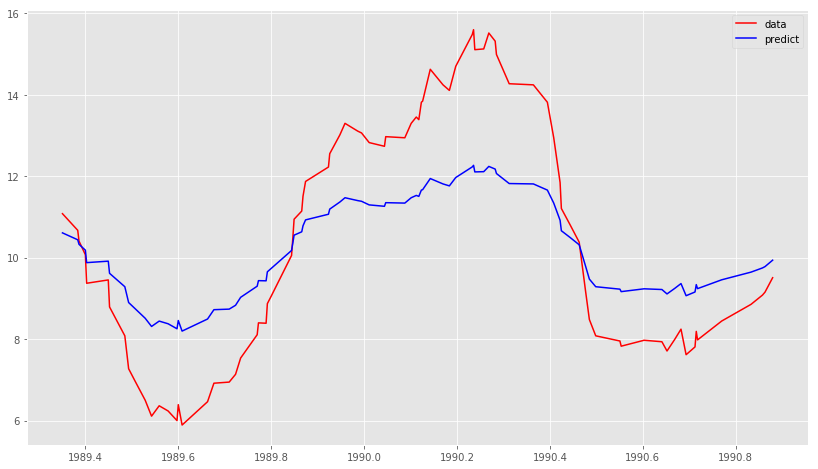

In [124]:
drop_out_list = [0.1, 0.2, 0.3, 0.4]
predict_list = []
var_list = []

for drop_out in drop_out_list:
    model = create_model(input_dim, 
                         time_steps=time_steps,
                         latent_dim=120,
                         model_option='lstm',
                         drop_out=drop_out,
                        )
    model.fit(x, x, epochs=200)
    window = time_steps
    x_test, scaler = prepare_data(X_smooth_test, time_steps)
    predict_test, x_scale_train = predict_model_show_graph(X_test_day_smooth[window + 1:], x_test, scaler, model)
    predict_list.append(predict_test)
    var_list.append(np.average(np.subtract(x_test, predict_test) ** 2))

# RMSEと分散を計算

In [125]:
average_predict = np.average(predict_list, axis=0)
average_predict = np.swapaxes(average_predict, 0, 1)[0]
average_predict = np.swapaxes(average_predict, 0, 1)[0]
rmse = np.sqrt(np.average(np.subtract(X_smooth_test[window + 1:], average_predict) ** 2))
variance = np.sqrt(np.average(var_list))
print('rmse:', rmse)
print('variance: ', variance)
noise_high_drop_out = [np.random.normal(y_p, variance) for y_p in average_predict]


rmse: 1.6292342203265353
variance:  9.44506174366974


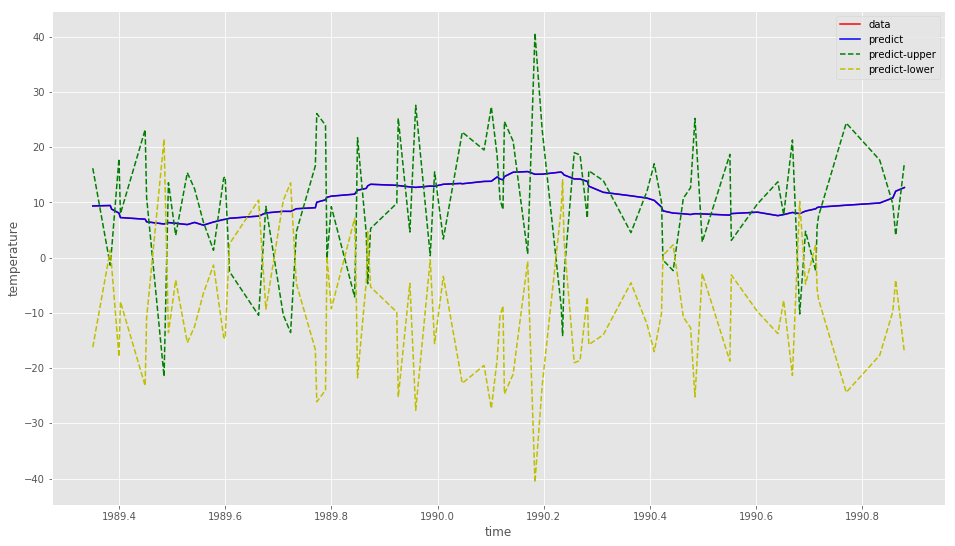

In [126]:
show_three_graph(X_test_day_smooth[window + 1:], 
                 X_smooth_test[window + 1:], 
                 average_predict, 
                 noise_high_drop_out, 
                 -1.0 * np.array(noise_high_drop_out))

# Coverageを計算

In [127]:
X_test = X_smooth_test[window + 1:]
noise = np.array(noise_high_drop_out)
coverage_test = []

for i in range(X_test.shape[0]):
    if noise[i] > X_test[i]:  # noqa
        coverage_test.append(True)
    elif -1.0 * noise[i] < X_test[i]:  # noqa
        coverage_test.append(True)
    else:
        coverage_test.append(False)
        
print(sum(coverage_test) / len(coverage_test))

0.9418604651162791


# Dropoutにより不確実性を導出

ノイズが多い分布を仮定

50,60,70,80%のノイズを付与

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_74 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_74 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_74 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 8s 20ms/step - loss: 0.1861 - mean_squared_error: 0.1861
Epoch 2/200
386/386 [==============================] - 0s 207us/step - loss: 0.1133 - mean_squared_error: 0.1133
Epoch 3/200
386/386 [==============================] - 0s 212us/step - loss: 0.0926 - mean_squared_error: 0.0926
Epoch 4/200
386/386 [==============================] - 0s 200us/

386/386 [==============================] - 0s 210us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 67/200
386/386 [==============================] - 0s 205us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 68/200
386/386 [==============================] - 0s 206us/step - loss: 0.0247 - mean_squared_error: 0.0247
Epoch 69/200
386/386 [==============================] - 0s 199us/step - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 70/200
386/386 [==============================] - 0s 204us/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 71/200
386/386 [==============================] - 0s 197us/step - loss: 0.0282 - mean_squared_error: 0.0282
Epoch 72/200
386/386 [==============================] - 0s 208us/step - loss: 0.0259 - mean_squared_error: 0.0259
Epoch 73/200
386/386 [==============================] - 0s 194us/step - loss: 0.0261 - mean_squared_error: 0.0261
Epoch 74/200
386/386 [==============================] - 0s 197us/step - loss: 0.0310 - mean_squared_e

386/386 [==============================] - 0s 202us/step - loss: 0.0244 - mean_squared_error: 0.0244
Epoch 138/200
386/386 [==============================] - 0s 198us/step - loss: 0.0278 - mean_squared_error: 0.0278
Epoch 139/200
386/386 [==============================] - 0s 199us/step - loss: 0.0240 - mean_squared_error: 0.0240
Epoch 140/200
386/386 [==============================] - 0s 209us/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 141/200
386/386 [==============================] - 0s 199us/step - loss: 0.0226 - mean_squared_error: 0.0226
Epoch 142/200
386/386 [==============================] - 0s 202us/step - loss: 0.0214 - mean_squared_error: 0.0214
Epoch 143/200
386/386 [==============================] - 0s 209us/step - loss: 0.0222 - mean_squared_error: 0.0222
Epoch 144/200
386/386 [==============================] - 0s 201us/step - loss: 0.0247 - mean_squared_error: 0.0247
Epoch 145/200
386/386 [==============================] - 0s 205us/step - loss: 0.0255 - mean_s

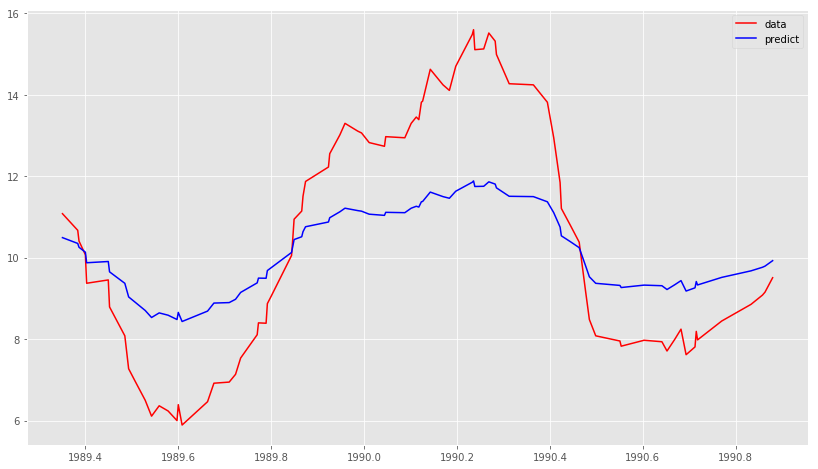

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_75 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_75 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_75 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 6s 16ms/step - loss: 0.2126 - mean_squared_error: 0.2126
Epoch 2/200
386/386 [==============================] - 0s 195us/step - loss: 0.1277 - mean_squared_error: 0.1277
Epoch 3/200
386/386 [==============================] - 0s 202us/step - loss: 0.0994 - mean_squared_error: 0.0994
Epoch 4/200
386/386 [==============================] - 0s 204us/

386/386 [==============================] - 0s 210us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 67/200
386/386 [==============================] - 0s 209us/step - loss: 0.0311 - mean_squared_error: 0.0311
Epoch 68/200
386/386 [==============================] - 0s 207us/step - loss: 0.0307 - mean_squared_error: 0.0307
Epoch 69/200
386/386 [==============================] - 0s 206us/step - loss: 0.0332 - mean_squared_error: 0.0332
Epoch 70/200
386/386 [==============================] - 0s 201us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 71/200
386/386 [==============================] - 0s 229us/step - loss: 0.0329 - mean_squared_error: 0.0329
Epoch 72/200
386/386 [==============================] - 0s 208us/step - loss: 0.0352 - mean_squared_error: 0.0352
Epoch 73/200
386/386 [==============================] - 0s 200us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 74/200
386/386 [==============================] - 0s 203us/step - loss: 0.0311 - mean_squared_e

386/386 [==============================] - 0s 231us/step - loss: 0.0317 - mean_squared_error: 0.0317
Epoch 138/200
386/386 [==============================] - 0s 211us/step - loss: 0.0294 - mean_squared_error: 0.0294
Epoch 139/200
386/386 [==============================] - 0s 204us/step - loss: 0.0301 - mean_squared_error: 0.0301
Epoch 140/200
386/386 [==============================] - 0s 202us/step - loss: 0.0300 - mean_squared_error: 0.0300
Epoch 141/200
386/386 [==============================] - 0s 203us/step - loss: 0.0330 - mean_squared_error: 0.0330
Epoch 142/200
386/386 [==============================] - 0s 195us/step - loss: 0.0312 - mean_squared_error: 0.0312
Epoch 143/200
386/386 [==============================] - 0s 196us/step - loss: 0.0281 - mean_squared_error: 0.0281
Epoch 144/200
386/386 [==============================] - 0s 198us/step - loss: 0.0299 - mean_squared_error: 0.0299
Epoch 145/200
386/386 [==============================] - 0s 197us/step - loss: 0.0322 - mean_s

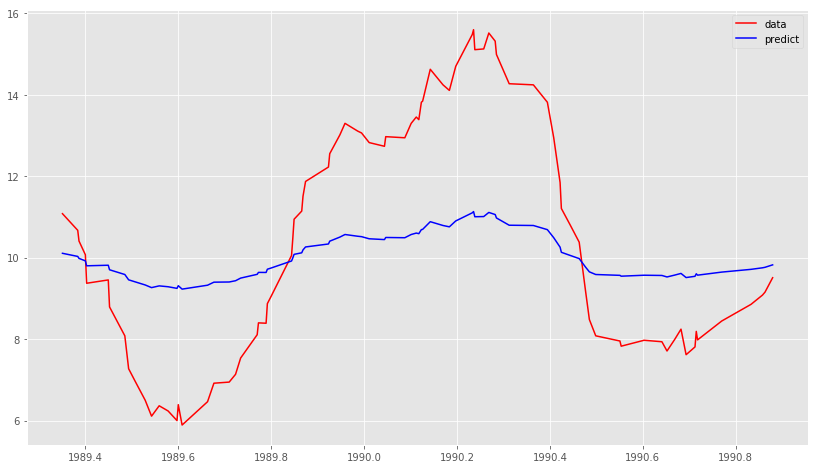

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_76 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_76 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 17ms/step - loss: 0.1949 - mean_squared_error: 0.1949
Epoch 2/200
386/386 [==============================] - 0s 210us/step - loss: 0.1272 - mean_squared_error: 0.1272
Epoch 3/200
386/386 [==============================] - 0s 214us/step - loss: 0.1010 - mean_squared_error: 0.1010
Epoch 4/200
386/386 [==============================] - 0s 201us/

386/386 [==============================] - 0s 197us/step - loss: 0.0381 - mean_squared_error: 0.0381
Epoch 67/200
386/386 [==============================] - 0s 221us/step - loss: 0.0372 - mean_squared_error: 0.0372
Epoch 68/200
386/386 [==============================] - 0s 222us/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 69/200
386/386 [==============================] - 0s 208us/step - loss: 0.0366 - mean_squared_error: 0.0366
Epoch 70/200
386/386 [==============================] - 0s 222us/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 71/200
386/386 [==============================] - 0s 233us/step - loss: 0.0371 - mean_squared_error: 0.0371
Epoch 72/200
386/386 [==============================] - 0s 205us/step - loss: 0.0380 - mean_squared_error: 0.0380
Epoch 73/200
386/386 [==============================] - 0s 204us/step - loss: 0.0390 - mean_squared_error: 0.0390
Epoch 74/200
386/386 [==============================] - 0s 213us/step - loss: 0.0395 - mean_squared_e

386/386 [==============================] - 0s 218us/step - loss: 0.0383 - mean_squared_error: 0.0383
Epoch 138/200
386/386 [==============================] - 0s 216us/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 139/200
386/386 [==============================] - 0s 208us/step - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 140/200
386/386 [==============================] - 0s 200us/step - loss: 0.0338 - mean_squared_error: 0.0338
Epoch 141/200
386/386 [==============================] - 0s 205us/step - loss: 0.0369 - mean_squared_error: 0.0369
Epoch 142/200
386/386 [==============================] - 0s 198us/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 143/200
386/386 [==============================] - 0s 201us/step - loss: 0.0340 - mean_squared_error: 0.0340
Epoch 144/200
386/386 [==============================] - 0s 200us/step - loss: 0.0348 - mean_squared_error: 0.0348
Epoch 145/200
386/386 [==============================] - 0s 224us/step - loss: 0.0364 - mean_s

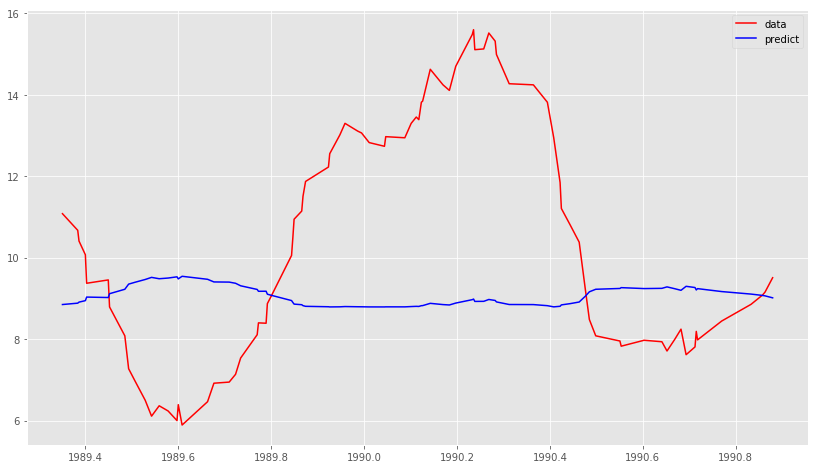

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_77 (InputLayer)        (None, 3, 1)              0         
_________________________________________________________________
lstm_77 (LSTM)               (None, 3, 120)            58560     
_________________________________________________________________
dense_77 (Dense)             (None, 3, 1)              121       
Total params: 58,681
Trainable params: 58,681
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
386/386 [==============================] - 7s 17ms/step - loss: 0.2139 - mean_squared_error: 0.2139
Epoch 2/200
386/386 [==============================] - 0s 211us/step - loss: 0.1432 - mean_squared_error: 0.1432
Epoch 3/200
386/386 [==============================] - 0s 208us/step - loss: 0.0951 - mean_squared_error: 0.0951
Epoch 4/200
386/386 [==============================] - 0s 215us/

386/386 [==============================] - 0s 226us/step - loss: 0.0423 - mean_squared_error: 0.0423
Epoch 67/200
386/386 [==============================] - 0s 209us/step - loss: 0.0422 - mean_squared_error: 0.0422
Epoch 68/200
386/386 [==============================] - 0s 203us/step - loss: 0.0431 - mean_squared_error: 0.0431
Epoch 69/200
386/386 [==============================] - 0s 204us/step - loss: 0.0463 - mean_squared_error: 0.0463
Epoch 70/200
386/386 [==============================] - 0s 203us/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 71/200
386/386 [==============================] - 0s 203us/step - loss: 0.0420 - mean_squared_error: 0.0420
Epoch 72/200
386/386 [==============================] - 0s 219us/step - loss: 0.0443 - mean_squared_error: 0.0443
Epoch 73/200
386/386 [==============================] - 0s 214us/step - loss: 0.0446 - mean_squared_error: 0.0446
Epoch 74/200
386/386 [==============================] - 0s 219us/step - loss: 0.0418 - mean_squared_e

386/386 [==============================] - 0s 247us/step - loss: 0.0427 - mean_squared_error: 0.0427
Epoch 138/200
386/386 [==============================] - 0s 234us/step - loss: 0.0440 - mean_squared_error: 0.0440
Epoch 139/200
386/386 [==============================] - 0s 220us/step - loss: 0.0418 - mean_squared_error: 0.0418
Epoch 140/200
386/386 [==============================] - 0s 208us/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 141/200
386/386 [==============================] - 0s 218us/step - loss: 0.0408 - mean_squared_error: 0.0408
Epoch 142/200
386/386 [==============================] - 0s 222us/step - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 143/200
386/386 [==============================] - 0s 240us/step - loss: 0.0420 - mean_squared_error: 0.0420
Epoch 144/200
386/386 [==============================] - 0s 238us/step - loss: 0.0401 - mean_squared_error: 0.0401
Epoch 145/200
386/386 [==============================] - 0s 219us/step - loss: 0.0383 - mean_s

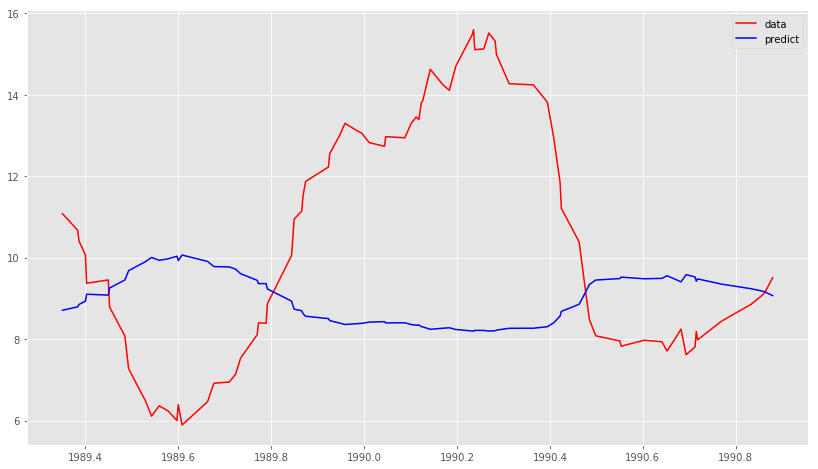

In [128]:
drop_out_list = [0.5, 0.6, 0.7, 0.8]
predict_list = []
var_list = []

for drop_out in drop_out_list:
    model = create_model(input_dim, 
                         time_steps=time_steps,
                         latent_dim=120,
                         model_option='lstm',
                         drop_out=drop_out,
                        )
    model.fit(x, x, epochs=200)
    window = time_steps
    x_test, scaler = prepare_data(X_smooth_test, time_steps)
    predict_test, x_scale_train = predict_model_show_graph(X_test_day_smooth[window + 1:], x_test, scaler, model)
    predict_list.append(predict_test)
    var_list.append(np.average(np.subtract(x_test, predict_test) ** 2))

# RMSEと分散を計算

In [129]:
average_predict = np.average(predict_list, axis=0)
average_predict = np.swapaxes(average_predict, 0, 1)[0]
average_predict = np.swapaxes(average_predict, 0, 1)[0]
rmse = np.sqrt(np.average(np.subtract(X_smooth_test[window + 1:], average_predict) ** 2))
variance = np.sqrt(np.average(var_list))
print('rmse:', rmse)
print('variance: ', variance)
noise_high_drop_out = [np.random.normal(y_p, variance) for y_p in average_predict]


rmse: 2.8866083856454576
variance:  8.150609387487762


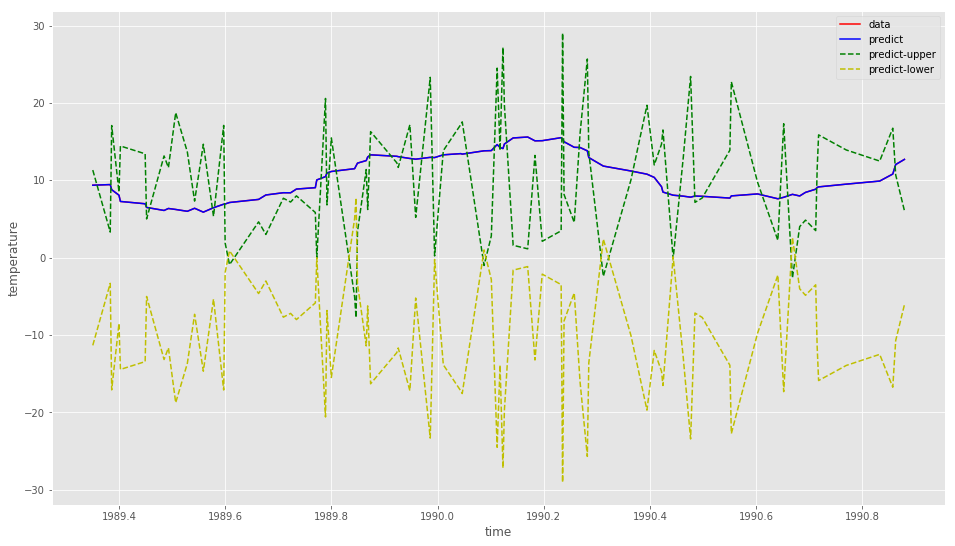

In [130]:
show_three_graph(X_test_day_smooth[window + 1:], 
                 X_smooth_test[window + 1:], 
                 average_predict, 
                 noise_high_drop_out, 
                 -1.0 * np.array(noise_high_drop_out))

# Coverageを計算

In [135]:
X_test = X_smooth_test[window + 1:]
noise = np.array(noise_high_drop_out)
coverage_test = []
print(noise.shape)

for i in range(X_test.shape[0]):
    if noise[i] > X_test[i]:  # noqa
        coverage_test.append(True)
    elif -1.0 * noise[i] < X_test[i]:  # noqa
        coverage_test.append(True)
    else:
        coverage_test.append(False)
        
print(sum(coverage_test) / len(coverage_test))

(86,)
1.0
